<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DBSCAN Practice

---

You're now familiar with how DBSCAN works. Let's practice it in sklearn.

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import cluster
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist, squareform


import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## NHL data


Now we will try DBSCAN on some [NHL data](https://github.com/josephnelson93/GA-DSI/blob/master/NHL_Data_GA.csv). We're going to investigate clustering teams based on their counting stats.

[Check out this glossary of hockey terms for a reference of what the columns indicate.](https://en.wikipedia.org/wiki/Ice_hockey_statistics)

### 1.  Load our data and perform any basic cleaning and/or EDA.

In [2]:
nhl = pd.read_csv('../../../../../resource-datasets/nhl_data/NHL_Data_GA.csv')
nhl.head()

,Team,PTS,Rank,TOI,GF,GA,GF60,GA60,GF%,SF,...,FF%,CF,CA,CF60,CA60,CF%,Sh%,Sv%,PDO,PIM
0,Washington10,121,1,2001:52:00,115,73,3.45,2.19,61.2,1112,...,51.3,2138,1935,64.1,58.0,52.5,10.34,93.03,1034,1269
1,Vancouver11,117,1,2056:14:00,94,72,2.74,2.10,56.6,1143,...,53.1,2144,1870,62.6,54.6,53.4,8.22,93.16,1014,985
2,San Jose10,113,1,1929:54:00,90,68,2.80,2.11,57.0,1065,...,50.9,1985,1876,61.7,58.3,51.4,8.45,93.46,1019,1195
3,Chicago10,112,1,2020:23:00,104,83,3.09,2.46,55.6,1186,...,58.1,2093,1572,62.2,46.7,57.1,8.77,90.44,992,966
4,Vancouver12,111,1,2052:02:00,86,74,2.51,2.16,53.8,1078,...,51.0,2085,1880,61.0,55.0,52.6,7.98,93.36,1013,1049


In [3]:
# first, check out dtypes
print(nhl.dtypes)  # TOI is an object - let's parse it

Team     object
PTS       int64
Rank      int64
TOI      object
GF        int64
GA        int64
GF60    float64
GA60    float64
GF%     float64
SF        int64
SA        int64
SF60    float64
SA60    float64
SF%     float64
FF        int64
FA        int64
FF60    float64
FA60    float64
FF%     float64
CF        int64
CA        int64
CF60    float64
CA60    float64
CF%     float64
Sh%     float64
Sv%     float64
PDO       int64
PIM       int64
dtype: object


In [4]:
# grab the first four digits, make them an integer
nhl.TOI = nhl.TOI.apply(lambda x: x.split(':')[0])

In [5]:
# now make it an int (or to_numeric)
nhl.TOI = nhl.TOI.apply(lambda x: int(x))

In [6]:
print(nhl.dtypes)

Team     object
PTS       int64
Rank      int64
TOI       int64
GF        int64
GA        int64
GF60    float64
GA60    float64
GF%     float64
SF        int64
SA        int64
SF60    float64
SA60    float64
SF%     float64
FF        int64
FA        int64
FF60    float64
FA60    float64
FF%     float64
CF        int64
CA        int64
CF60    float64
CA60    float64
CF%     float64
Sh%     float64
Sv%     float64
PDO       int64
PIM       int64
dtype: object


### 2. Set up an `X` matrix to perform clustering with DBSCAN.

Let's cluster on all features EXCEPT team and rank.

Make rank be our `y` vector which we can use to do cluster validation. 

In [7]:
X = nhl.drop(['Team', 'Rank', 'PTS'], axis=1)

y = nhl.Rank
print(y[0:5])
X.head(2)

0    1
1    1
2    1
3    1
4    1
Name: Rank, dtype: int64


,TOI,GF,GA,GF60,GA60,GF%,SF,SA,SF60,SA60,...,FF%,CF,CA,CF60,CA60,CF%,Sh%,Sv%,PDO,PIM
0,2001,115,73,3.45,2.19,61.2,1112,1047,33.3,31.4,...,51.3,2138,1935,64.1,58.0,52.5,10.34,93.03,1034,1269
1,2056,94,72,2.74,2.10,56.6,1143,1053,33.4,30.7,...,53.1,2144,1870,62.6,54.6,53.4,8.22,93.16,1014,985


### 3. Scatter plot EDA

Make two scatter plots. At least one axis in one of the plots should represent points (goals for example, GA). Do we obtain a general idea from the scatter plots of how many clusters we should expect to extract with a clustering algorithm?

In [8]:
# remember columns we can plot
print(X.columns.values)

['TOI' 'GF' 'GA' 'GF60' 'GA60' 'GF%' 'SF' 'SA' 'SF60' 'SA60' 'SF%' 'FF'
 'FA' 'FF60' 'FA60' 'FF%' 'CF' 'CA' 'CF60' 'CA60' 'CF%' 'Sh%' 'Sv%' 'PDO'
 'PIM']


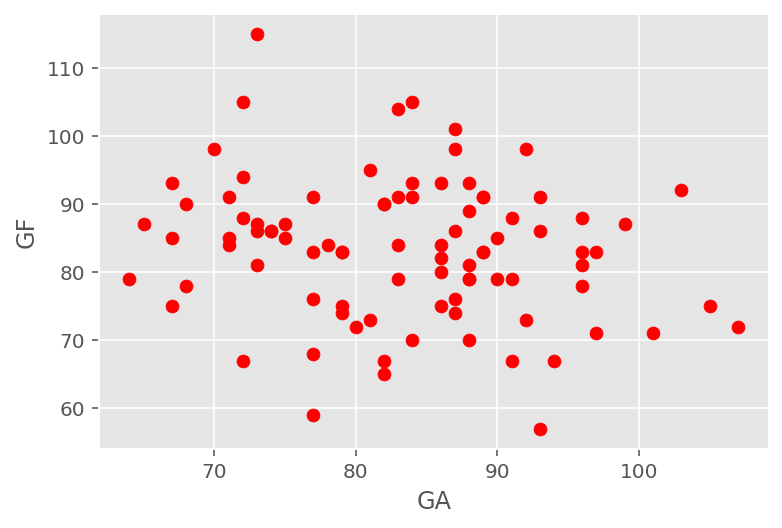

In [9]:
X.plot(x='GA', y='GF', kind='scatter', s=40, c='r')
plt.show()

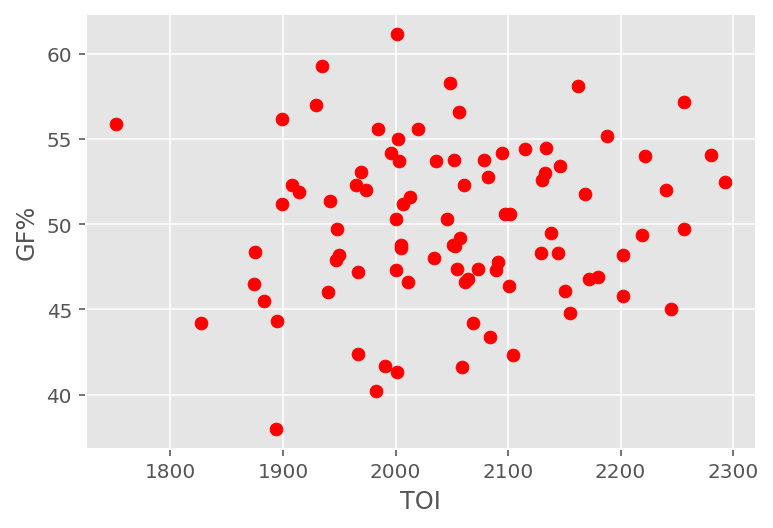

In [10]:
X.plot(x='TOI', y='GF%', kind='scatter', s=40, c='r')
plt.show()

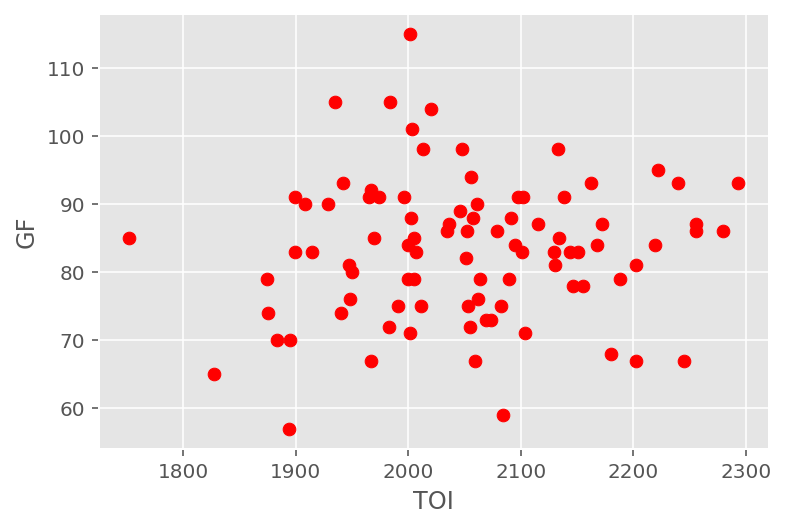

In [11]:
X.plot(x='TOI', y='GF', kind='scatter', s=40, c='r')
plt.show()

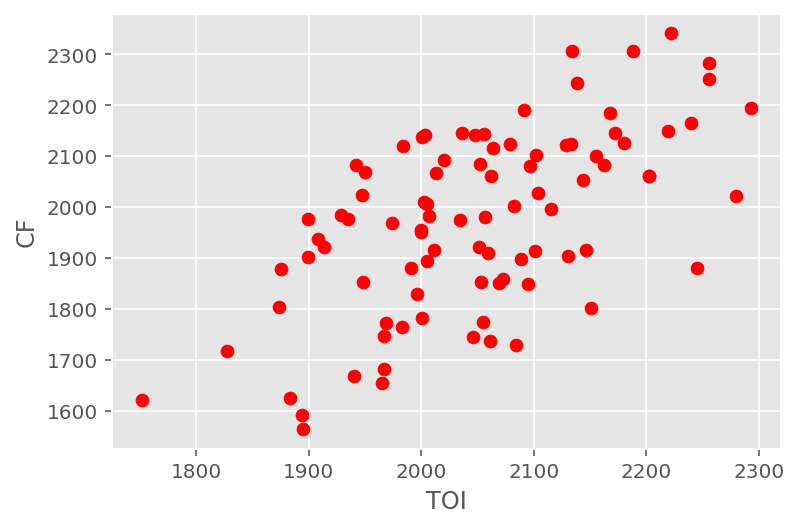

In [12]:
X.plot(x='TOI', y='CF', kind='scatter', s=40, c='r')
plt.show()

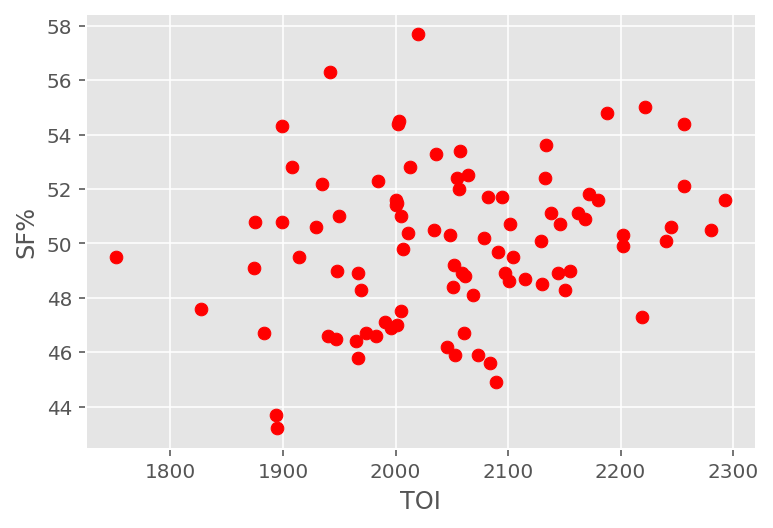

In [13]:
X.plot(x='TOI', y='SF%', kind='scatter', s=40, c='r')
plt.show()

## 4. Scale our data

Standardize the data and compare at least one of the scatterplots for the scaled data to unscaled above.

In [14]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xs = pd.DataFrame(Xs, columns=X.columns)

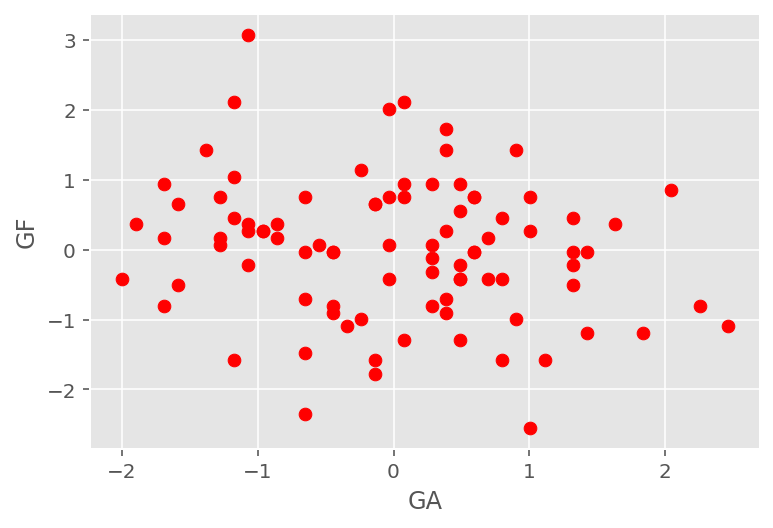

In [15]:
# Goals against vs. goals for
Xs.plot(x='GA', y='GF', kind='scatter', s=40, c='r')
plt.show()

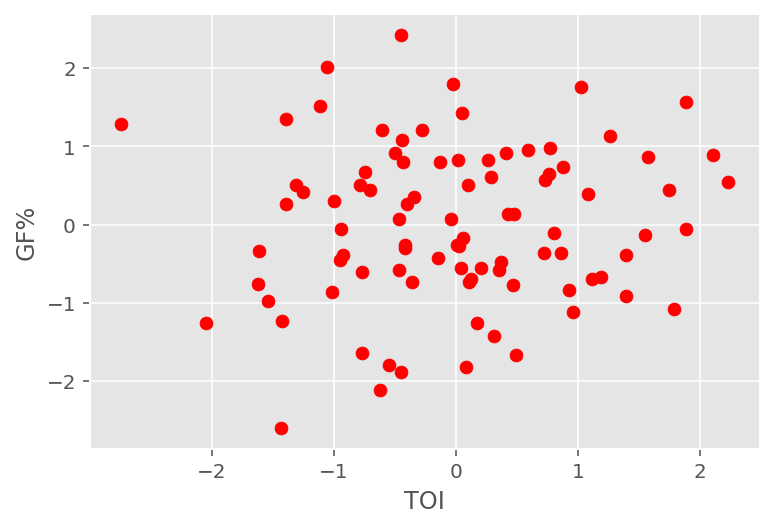

In [16]:
# Goals for percent vs. time on ice
Xs.plot(x='TOI', y='GF%', kind='scatter', s=40, c='r')
plt.show()

### 5. Fit a DBSCAN clusterer

Remember to pass an `eps` and `min_samples` of your choice.

In [17]:
dbscan = DBSCAN(eps=3, min_samples=3)
dbscan.fit(Xs)

# 'eps' is the max distance between two samples in order for them to be considered in the some cluster.
# min_samples = Minimum number of samples required for a cluster to be considered a cluster.

DBSCAN(algorithm='auto', eps=3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=3, n_jobs=None, p=None)

### 6. Check out the assigned cluster labels

Using the `.labels_` command on our DBSCAN class

In [18]:
labels = dbscan.labels_
print(labels)  # comprehension: what do these mean? How many are there?
# Observations that did not make it into a DB qualified cluster will recieve the label of -1

[ 0  0  0 -1  0 -1 -1 -1 -1  0  0  0 -1 -1  1 -1 -1 -1  0  0 -1  0 -1 -1
 -1 -1 -1  0  0 -1  0  0  0 -1  0  0  0  0  2 -1 -1  0  0 -1  0  0 -1 -1
 -1  0  0 -1 -1 -1  0  0 -1  0  3  0 -1 -1 -1  3 -1  0 -1 -1  4 -1 -1  3
  3  0  2  2  1  0 -1  1 -1  0  2  2  4  0  0  0  4 -1]


In [19]:
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print(n_clusters_)

5


### 7. Evaluate the DBSCAN clusters

**7.1 Check the silhouette score.**

How are the clusters?

If you're feeling adventurous, see how you can adjust our epsilon and min_points to improve this.

**7.2 Check the homogeneity, completeness, and V-measure against the stored rank `y`**

In [20]:
def cluster_score(X, y, labels):
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, labels))
    print('Estimated number of clusters: %d' % n_clusters_)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))

In [21]:
cluster_score(Xs, y, labels)

Silhouette Coefficient: -0.012
Estimated number of clusters: 5
Homogeneity: 0.118
Completeness: 0.103
V-measure: 0.110


In [22]:
import numpy as np
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
print(core_samples[:10])

[False  True  True False  True False False False False  True]


### 8. Plot the clusters

Create a scatter plot with colors according to the cluster labels. You can choose any two variables for the axes. How do you judge the fit?

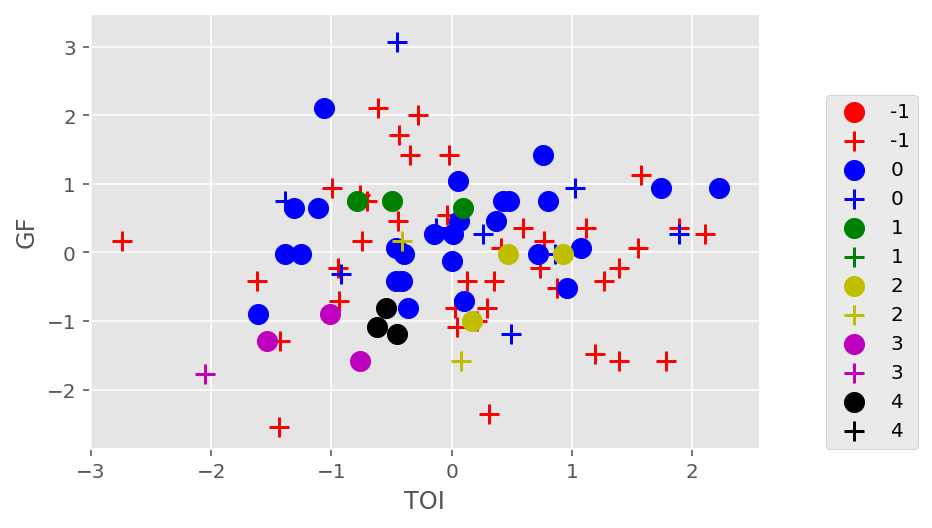

In [23]:
unique_labels = np.unique(labels)
colors = 'rbgymko'

for (label, color) in zip(unique_labels, colors):
    class_member_mask = (labels == label)
    n = Xs.loc[class_member_mask & core_samples, :]
    plt.scatter(n.iloc[:, 0], n.iloc[:, 1], c=color, s=100, label=label)

    n = Xs.loc[class_member_mask & ~core_samples, :]
    plt.scatter(n.iloc[:, 0], n.iloc[:, 1], c=color, marker='+', s=100, label=label)
    plt.xlabel(Xs.columns[0])
    plt.ylabel(Xs.columns[1])
    plt.legend(loc=[1.1, 0])

### 9. How does the result look like if you choose only the first few principal components?

In [24]:
from sklearn.decomposition import PCA

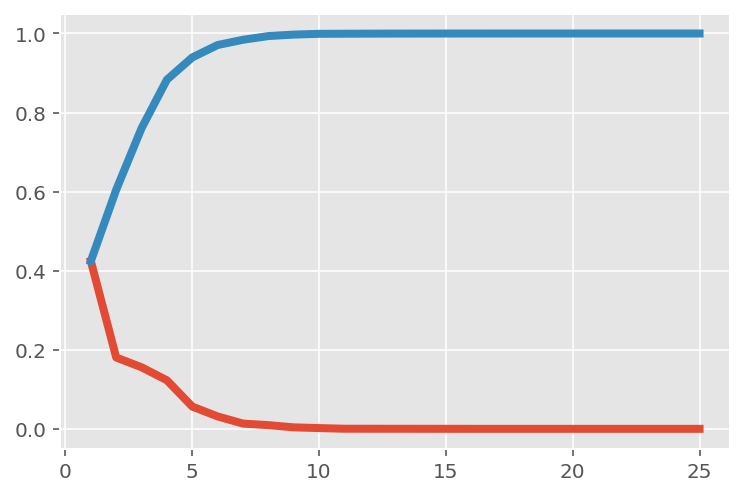

In [25]:
pca = PCA()
pca.fit(Xs)
plt.plot(list(range(1, len(pca.explained_variance_ratio_) + 1)),
         pca.explained_variance_ratio_, lw=4)
plt.plot(list(range(1, len(pca.explained_variance_ratio_) + 1)),
         np.cumsum(pca.explained_variance_ratio_), lw=4)
plt.show()

In [26]:
print(np.cumsum(pca.explained_variance_ratio_)[:10])

[0.42426195 0.60472304 0.7604282  0.88322191 0.93945969 0.97082482
 0.9841046  0.99347633 0.99720871 0.99912157]


In [27]:
Xs_pca = pd.DataFrame(pca.transform(Xs), columns=[
                      'PC_' + str(i) for i in range(1, Xs.shape[1] + 1)])

In [28]:
ncomp = 2
dbscan = DBSCAN(eps=1.2, min_samples=3, metric='euclidean')
dbscan.fit(Xs_pca.iloc[:, :ncomp])
labels = dbscan.labels_
print(labels)
# determine core samples
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[dbscan.core_sample_indices_] = True
# how many clusters do we have?
n_clusters_ = len(set(labels).difference(set([-1])))
print(n_clusters_)
cluster_score(Xs_pca, y, labels)

[ 0  0  0 -1  0  0  0  1  0  0  0  0  0  0  0  0 -1  0  1  0  0  0  1  0
  0  0 -1  0  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  2  0  3  0  0 -1  0  3  3  0  0 -1 -1 -1  2  3
  3  0  0  0  0  0  0  0 -1  0  0  0  2  0  0  0 -1 -1]
4
Silhouette Coefficient: -0.001
Estimated number of clusters: 4
Homogeneity: 0.114
Completeness: 0.141
V-measure: 0.126


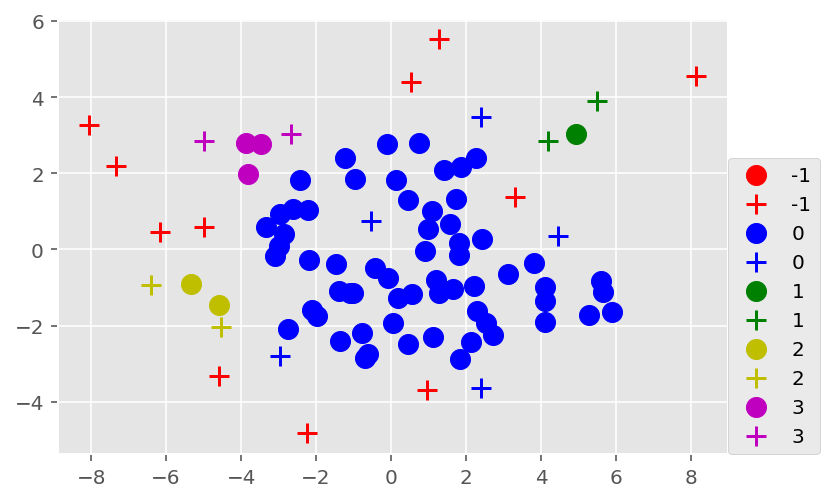

In [29]:
unique_labels = np.unique(labels)
colors = 'rbgymko'

for (label, color) in zip(unique_labels, colors):

    class_member_mask = (labels == label)
    n = Xs_pca.iloc[class_member_mask & core_samples, :ncomp]
    plt.scatter(n.iloc[:, 0], n.iloc[:, 1], c=color, s=100, label=label)
    
    n = Xs_pca.iloc[class_member_mask & ~core_samples, :ncomp]
    plt.scatter(n.iloc[:, 0], n.iloc[:, 1], c=color,
                marker='+', s=100, label=label)
    plt.legend(loc=[1, 0])

## Bonus:

## Try k-means and hierarchical clustering on the given datasets. Which differences do you observe? Which algorithm do you find most suitable in each case?

In [30]:
from sklearn.cluster import KMeans, AgglomerativeClustering

### K-Means

Silhouette Coefficient: 0.168
Estimated number of clusters: 4
Homogeneity: 0.253
Completeness: 0.204
V-measure: 0.226


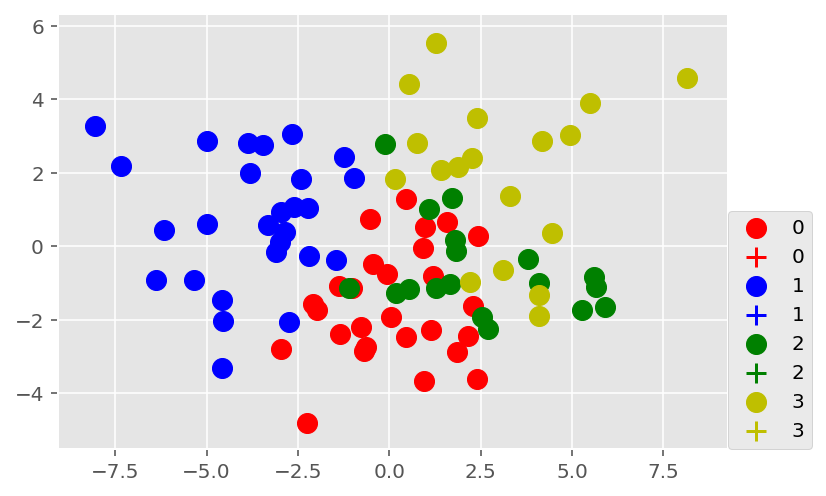

In [31]:
k_means = KMeans(n_clusters=4)
k_means.fit(Xs_pca)
labels = k_means.labels_
# print(labels)

# how many clusters do we have?
n_clusters_ = len(set(labels))
# print n_clusters_
cluster_score(Xs_pca, y, labels)

unique_labels = np.unique(labels)
colors = 'rbgymko'

for (label, color) in zip(unique_labels, colors):

    class_member_mask = (labels == label)
    n = Xs_pca.iloc[class_member_mask, :ncomp]
    plt.scatter(n.iloc[:, 0], n.iloc[:, 1], c=color, s=100, label=label)

    n = Xs_pca.iloc[class_member_mask, :ncomp]
    plt.scatter(n.iloc[:, 0], n.iloc[:, 1], c=color,
                marker='+', s=100, label=label)
    plt.legend(loc=[1, 0])

### Hierarchical Clustering

Silhouette Coefficient: 0.148
Estimated number of clusters: 4
Homogeneity: 0.179
Completeness: 0.143
V-measure: 0.159


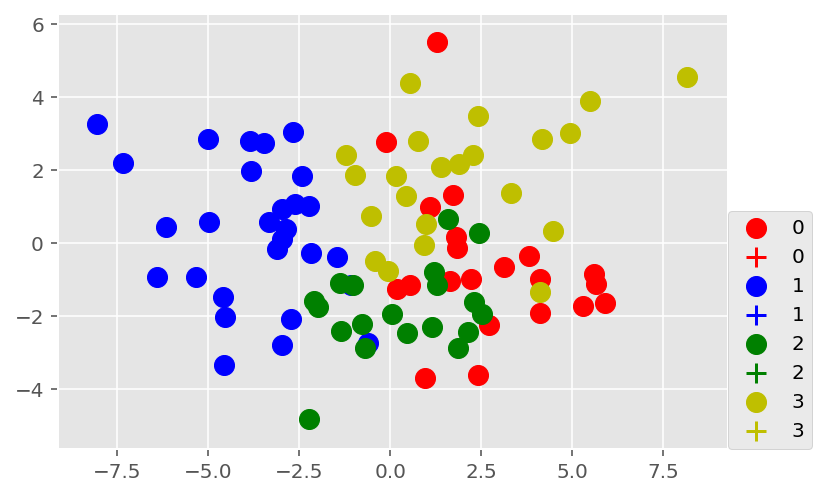

In [32]:
agg = AgglomerativeClustering(n_clusters=4)
agg.fit(Xs_pca)
labels = agg.labels_
# print(labels)

# how many clusters do we have?
n_clusters_ = len(set(labels))
# print n_clusters_
cluster_score(Xs_pca, y, labels)

unique_labels = np.unique(labels)
colors = 'rbgymko'

for (label, color) in zip(unique_labels, colors):

    class_member_mask = (labels == label)
    n = Xs_pca.iloc[class_member_mask, :ncomp]
    plt.scatter(n.iloc[:, 0], n.iloc[:, 1], c=color, s=100, label=label)

    n = Xs_pca.iloc[class_member_mask, :ncomp]
    plt.scatter(n.iloc[:, 0], n.iloc[:, 1], c=color,
                marker='+', s=100, label=label)
    plt.legend(loc=[1, 0])

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

In [34]:
Z = linkage(Xs_pca, 'average')
c, coph_dists = cophenet(Z, pdist(Xs_pca))

print(c)
print(len(coph_dists))
print(coph_dists.mean())

0.5531582372404734
4005
6.755095623397677


In [35]:
clusters = fcluster(Z, 2, criterion='maxclust')
print(len(set(clusters)))

2


In [36]:
cluster_score(Xs_pca, y, clusters)

Silhouette Coefficient: 0.206
Estimated number of clusters: 4
Homogeneity: 0.012
Completeness: 0.208
V-measure: 0.022


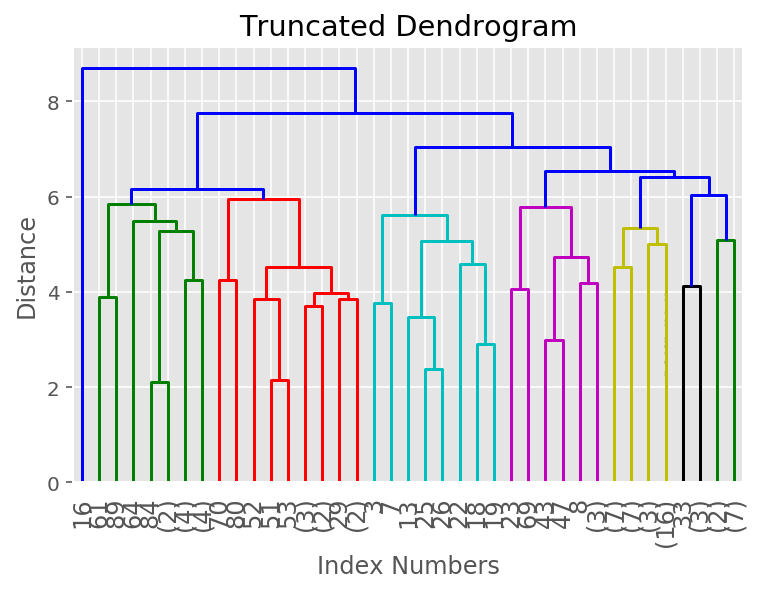

In [37]:
plt.title('Truncated Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(
    Z,
    truncate_mode='level',
    p=6,
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    color_threshold=6
)
plt.show()